In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import defaultdict
import dateutil.parser
from pprint import pprint
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
import seaborn as sns
import urllib2, sys
import string
import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool

%matplotlib inline

In [3]:
df = pd.read_csv('csv/moviedf_with_ratings.csv')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.head()

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month,decay rate,meta_rating
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.171526,68
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.181872,78
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.169169,33
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.265453,36
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,-0.114673,44


In [7]:
df = df.rename(columns={'distributor':'dist', 'domestic total gross': 'dom_tot_gross',
                                'movie title': 'title', 'number of theaters': 'num_theaters',
                                'opening weekend revenue': 'open_rev', 'production budget': 
                                'budget', 'release date': 'release', 'runtime (mins)': 'runtime',
                                'time in theaters (days)': 'time_theaters', 'release month': 'month',
                                'decay rate': 'decay'})

In [8]:
df.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay,meta_rating
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.171526,68
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.181872,78
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.169169,33
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.265453,36
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,-0.114673,44


In [9]:
unique_genres = df['genre'].unique()
print unique_genres

['Comedy' 'Action Thriller' 'War Romance' 'Drama' 'Horror Thriller'
 'Period Drama' 'Music Drama' 'Romantic Comedy' 'Family Adventure' 'Action'
 'Action Drama' 'Animation' 'Sci-Fi Action' 'Action / Adventure' 'War'
 'Fantasy' 'Family' 'Horror' 'Drama / Thriller' 'Sports Drama'
 'Family Comedy' 'Musical' 'Action Comedy' 'Sci-Fi' 'Crime Drama'
 'Sci-Fi Comedy' 'Sci-Fi Adventure' 'Crime Comedy' 'Crime Thriller'
 'Thriller' 'Period Adventure' 'Comedy / Drama' 'Romantic Thriller'
 'Action Horror' 'Documentary' 'Sci-Fi Horror' 'Fantasy Comedy'
 'Fantasy Drama' 'War Drama' 'Sports Comedy' 'Sci-Fi Thriller' 'Romance'
 'Horror Comedy' 'Comedy Thriller' 'Period Action' 'Foreign / Action'
 'Western Comedy' 'IMAX' 'Action Fantasy' 'Western' 'Historical Drama'
 'Action / Crime' 'Adventure' 'Crime' 'Period Comedy' 'Sci-Fi Fantasy'
 'Foreign / Horror' 'Sports Action' 'Period Horror' 'Foreign'
 'Historical Epic' 'Adventure Comedy' 'Romantic Adventure' 'Concert']


In [30]:
genre_dict = {'War Romance':'Drama', 'Horror Thriller':'Horror / Thriller', 'Period Drama':'Drama',
              'Music Drama':'Drama','Romantic Comedy':'Comedy', 'Action Drama':'Drama',
              'Sci-Fi Action': 'Action', 'Action / Adventure': 'Action', 'Fantasy': 'Sci-Fi',
              'Drama / Thriller': 'Drama', 'Sports Drama':'Drama', 'Horror': 'Horror / Thriller',
              'Action Thriller': 'Action', 'Action Comedy':'Comedy','Family Adventure':'Family', 
              'War':'Drama', 'Crime Comedy':'Comedy', 'Family Comedy':'Family', 'Comedy / Drama': 'Comedy',
              'Romantic Thriller':'Horror / Thriller', 'Thriller':'Horror / Thriller', 
              'Fantasy Comedy':'Comedy','Sci-Fi Horror':'Horror / Thriller', 'Fantasy Drama':'Drama', 
              'Sports Comedy':'Comedy', 'Sci-Fi Thriller':'Sci-Fi','Comedy Thriller':'Comedy', 'Horror Comedy':'Comedy',
              'Romance':'Drama', 'Period Action':'Action','Foreign / Action':'Action', 'IMAX':'Documentary', 
              'War Drama':'Drama', 'Crime Drama':'Drama', 'Action Horror':'Horror / Thriller', 'Western':'Action', 
              'Musical':'Drama', 'Sci-Fi Adventure':'Sci-Fi', 'Action / Crime':'Action', 'Crime Thriller':'Horror / Thriller',
              'Period Adventure':'Drama', 'Historical Drama':'Drama', 'Sci-Fi Comedy':'Comedy', 'Western Comedy':'Comedy',
              'Foreign / Horror':'Horror / Thriller', 'Action Fantasy':'Action', 'Crime':'Drama', 'Sports Action':'Action',
              'Period Horror':'Horror / Thriller', 'Historical Epic':'Drama', 'Adventure Comedy':'Comedy',
              'Adventure':'Action', 'Foreign':'Drama', 'Period Comedy':'Comedy', 'Romantic Adventure':'Drama', 
              'Concert':'Documentary', 'Sci-Fi Fantasy': 'Sci-Fi'}

In [31]:
df = df.replace({'genre' : genre_dict})

In [45]:
ratings_bin, bins = pd.cut(df['meta_rating'],5,retbins=True)
df['rating_bin'] = ratings_bin

In [46]:
df.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay,meta_rating,rating_bin
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.171526,68,"(60.4, 80.2]"
1,Fox,252358600.0,Action,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.181872,78,"(60.4, 80.2]"
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.169169,33,"(20.8, 40.6]"
3,Universal,39263600.0,Drama,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.265453,36,"(20.8, 40.6]"
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,-0.114673,44,"(40.6, 60.4]"


In [47]:
print len(df)

2475


In [48]:
df.count(axis=0)

dist             2475
dom_tot_gross    2475
genre            2475
title            2475
movieid          2475
num_theaters     2469
open_rev         2183
budget           1703
rating           2475
release          2475
runtime          2474
time_theaters    2475
month            2475
decay            2475
meta_rating      2475
rating_bin       2475
dtype: int64

In [49]:
df.to_csv('csv/final_data_4_20.csv',encoding='utf-8')

### Analysis of Variables

In [17]:
def plot_kde(df, category):
    dropped = df[category].dropna()
    density = gaussian_kde(dropped)
    xs = np.linspace(dropped.min(),dropped.max(),300)
    ys = density(xs)
    plt.plot(xs, ys)
    plt.title('PDF of ' + category)
    plt.ylabel('Probability')
    plt.xlabel(category)

In [18]:
def plot_bar(df, column):
    ys = df[column].value_counts(normalize=True, sort=False)
    xs = np.arange(len(ys))
    plt.figure(figsize=(18,5))
    plt.bar(xs, ys.values)
    plt.xticks(xs, ys.index, rotation=45)
    plt.ylabel('Percentage of Observations')

In [19]:
def plot_scatter(df, category):
    xs = df[category]
    ys = df['decay']
    plt.scatter(xs, ys)
#     plt.savefig('img/scatter'+category+'.png')

In [75]:
def plot_scatter_categorical(df, category):
    d = {}
    i = 0
    for c in df[category].unique():
        d[c] = i
        i += 1
    copy = df.copy(deep=True)
    copy[category + '_cat'] = copy[category].map(d)
    xs = copy[category + '_cat']
    ys = copy['decay']
    plt.scatter(xs, ys)

## Density Graphs

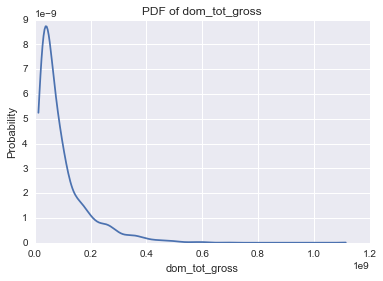

In [20]:
plot_kde(df, 'dom_tot_gross')

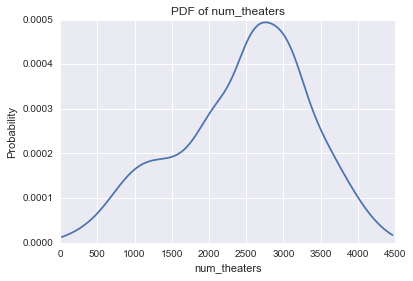

In [21]:
plot_kde(df, 'num_theaters')

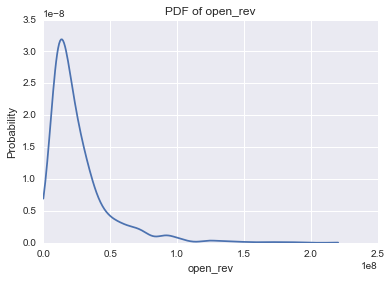

In [22]:
plot_kde(df, 'open_rev')

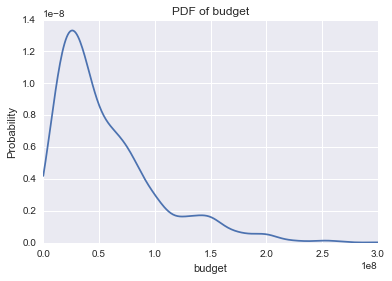

In [23]:
plot_kde(df, 'budget')

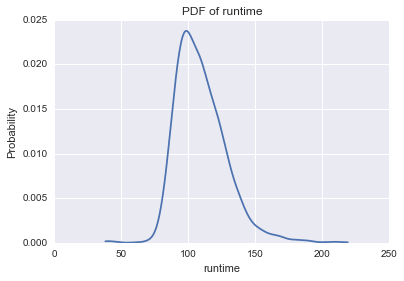

In [24]:
plot_kde(df, 'runtime')

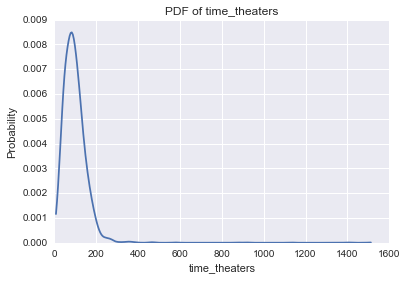

In [25]:
plot_kde(df, 'time_theaters')

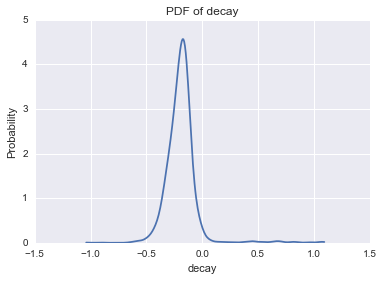

In [26]:
plot_kde(df, 'decay')

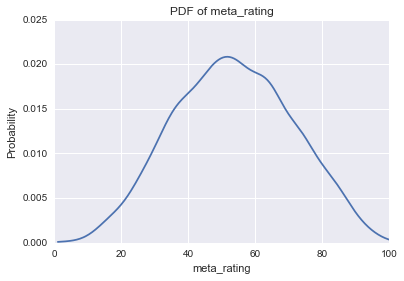

In [27]:
plot_kde(df, 'meta_rating')

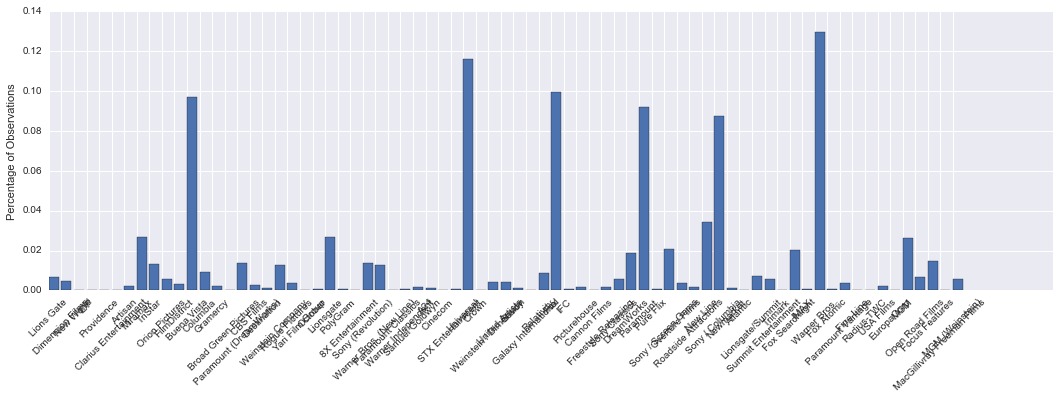

In [28]:
plot_bar(df, 'dist')

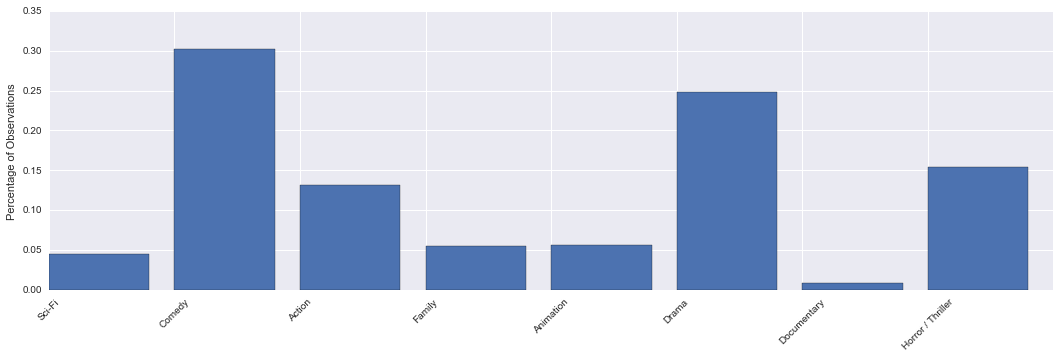

In [36]:
plot_bar(df, 'genre')

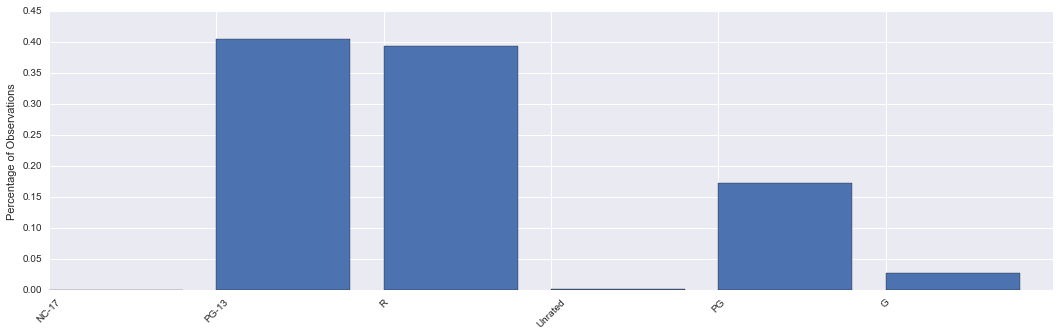

In [37]:
plot_bar(df, 'rating')

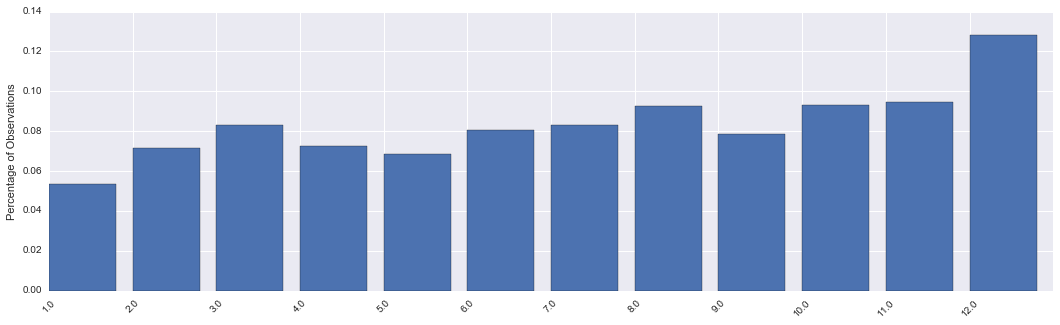

In [38]:
plot_bar(df, 'month')

## Relationship Graphs

([<matplotlib.axis.XTick at 0x113df5b50>,
 <a list of 8 Text xticklabel objects>)

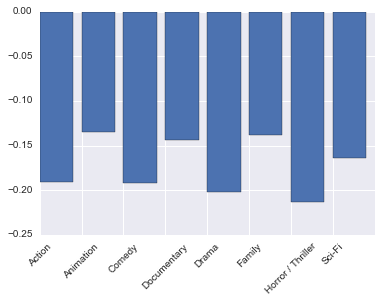

In [39]:
genre_avgs = df.groupby(by='genre')['decay'].mean()
genres = genre_avgs.index
xs = np.arange(len(genres))
plt.bar(xs,genre_avgs)
plt.xticks(xs,genres,rotation=45)

([<matplotlib.axis.XTick at 0x114143390>,
 <a list of 6 Text xticklabel objects>)

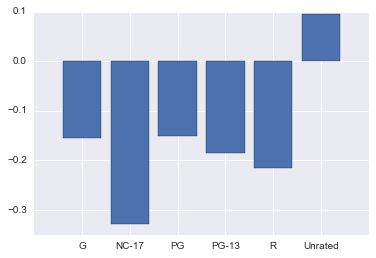

In [40]:
ratings_avgs = df.groupby(by='rating')['decay'].mean()
ratings = ratings_avgs.index
xs = np.arange(len(ratings))
plt.bar(xs,ratings_avgs,align='center')
plt.xticks(xs,ratings)

<Container object of 5 artists>

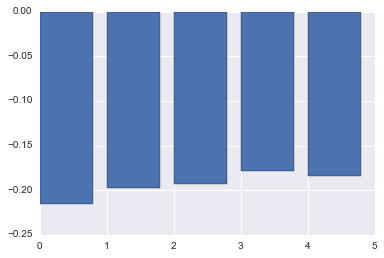

In [51]:
rating_bin_avgs = df.groupby(by='rating_bin')['decay'].mean()
xs = np.arange(len(rating_bin_avgs))
plt.bar(xs,rating_bin_avgs)

<Container object of 12 artists>

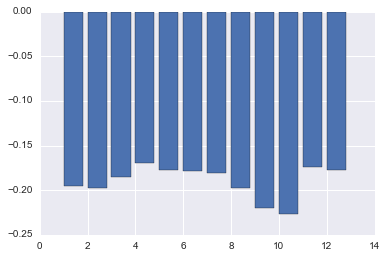

In [52]:
month_avgs = df.groupby(by='month')['decay'].mean()
months = np.arange(1,13)
plt.bar(months, month_avgs)

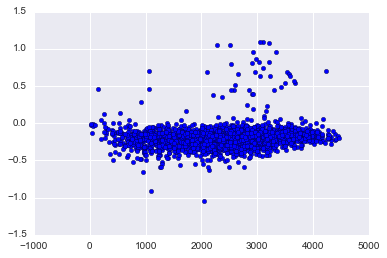

In [53]:
plot_scatter(df, 'num_theaters')

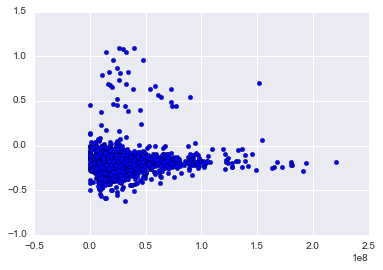

In [54]:
plot_scatter(df, 'open_rev') # This cannot be used because goes into decay rate calc

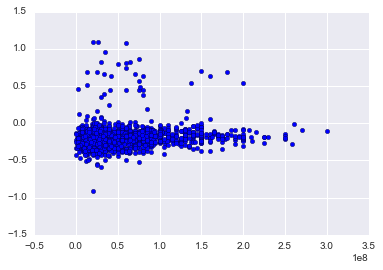

In [55]:
plot_scatter(df, 'budget')

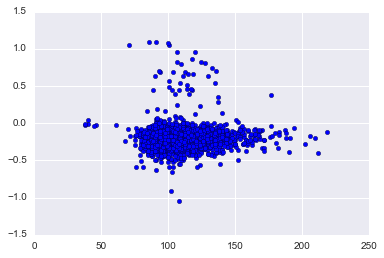

In [56]:
plot_scatter(df, 'runtime')

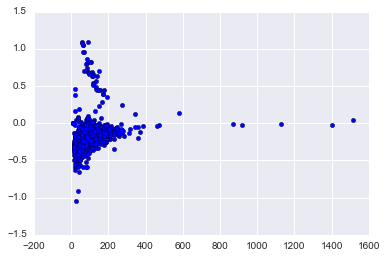

In [57]:
plot_scatter(df, 'time_theaters') # This cannot be used because goes into decay rate calc

# Create Models #

In [60]:
from patsy import dmatrices, dmatrix
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold

In [142]:
statsdf = pd.read_csv('csv/final_data_4_20.csv')

In [145]:
statsdf.drop('Unnamed: 0', axis=1, inplace=True)

In [149]:
statsdf.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay,meta_rating,rating_bin
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.171526,68,"(60.4, 80.2]"
1,Fox,252358600.0,Action,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.181872,78,"(60.4, 80.2]"
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.169169,33,"(20.8, 40.6]"
3,Universal,39263600.0,Drama,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.265453,36,"(20.8, 40.6]"
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,-0.114673,44,"(40.6, 60.4]"


In [155]:
# Drop the variables not being used
modeldf = statsdf.drop('rating_bin', axis=1)
modeldf.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay,meta_rating
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.171526,68
1,Fox,252358600.0,Action,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.181872,78
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.169169,33
3,Universal,39263600.0,Drama,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.265453,36
4,DreamWorks,55006600.0,Comedy,Head of State,7,2256.0,19482600.0,NaN,PG-13,2003-03-28,95.0,112.0,3.0,-0.114673,44


In [156]:
modeldf.drop('title', axis=1, inplace=True)
modeldf.drop('movieid', axis=1, inplace=True)
modeldf.drop('dist', axis=1, inplace=True)
modeldf.drop('release', axis=1, inplace=True)

In [157]:
def add_binary(df, column_list, category):
    for c in column_list:
        df[c] = np.where(df[category] == c, 1, 0)
    df.drop(category, axis=1, inplace=True)
    return df

In [158]:
modeldf = add_binary(modeldf,modeldf['rating'].unique(), 'rating')
modeldf = add_binary(modeldf, modeldf['month'].unique(), 'month')
modeldf = add_binary(modeldf, modeldf['genre'].unique(), 'genre')
modeldf.head()

,dom_tot_gross,num_theaters,open_rev,budget,runtime,time_theaters,decay,meta_rating,PG,R,...,10.0,1.0,Comedy,Action,Drama,Horror / Thriller,Family,Animation,Sci-Fi,Documentary
0,90944400.0,1515.0,8129500.0,NaN,110.0,56.0,-0.171526,68,1,0,...,0,0,1,0,0,0,0,0,0,0
1,252358600.0,2169.0,30088300.0,30000000.0,116.0,70.0,-0.181872,78,0,1,...,0,0,0,1,0,0,0,0,0,0
2,48884600.0,2128.0,14084800.0,75000000.0,90.0,105.0,-0.169169,33,0,0,...,0,0,1,0,0,0,0,0,0,0
3,39263600.0,1612.0,11081500.0,57000000.0,129.0,63.0,-0.265453,36,0,1,...,0,0,0,0,1,0,0,0,0,0
4,55006600.0,2256.0,19482600.0,NaN,95.0,112.0,-0.114673,44,0,0,...,0,0,1,0,0,0,0,0,0,0


In [159]:
modeldf_nonulls = modeldf.dropna(axis=0, how='any')
modeldf_nonulls.head()

,dom_tot_gross,num_theaters,open_rev,budget,runtime,time_theaters,decay,meta_rating,PG,R,...,10.0,1.0,Comedy,Action,Drama,Horror / Thriller,Family,Animation,Sci-Fi,Documentary
1,252358600.0,2169.0,30088300.0,30000000.0,116.0,70.0,-0.181872,78,0,1,...,0,0,0,1,0,0,0,0,0,0
2,48884600.0,2128.0,14084800.0,75000000.0,90.0,105.0,-0.169169,33,0,0,...,0,0,1,0,0,0,0,0,0,0
3,39263600.0,1612.0,11081500.0,57000000.0,129.0,63.0,-0.265453,36,0,1,...,0,0,0,0,1,0,0,0,0,0
8,174694300.0,2585.0,76728500.0,41000000.0,118.0,140.0,0.441899,77,0,1,...,0,0,0,0,1,0,0,0,0,0
11,108847100.0,3122.0,35028600.0,90000000.0,99.0,142.0,-0.070898,34,1,0,...,0,0,0,0,0,0,1,0,0,0


## Lasso Model with Cross Validation ##

In [174]:
col_list = modeldf_nonulls.columns.tolist()
fhalf = col_list[:6]
shalf = col_list[7:]
x_cols = fhalf + shalf
print x_cols

['dom_tot_gross', 'num_theaters', 'open_rev', 'budget', 'runtime', 'time_theaters', 'meta_rating', 'PG', 'R', 'PG-13', 'G', 'Unrated', 'NC-17', 12.0, 6.0, 4.0, 8.0, 3.0, 11.0, 5.0, 2.0, 9.0, 7.0, 10.0, 1.0, 'Comedy', 'Action', 'Drama', 'Horror / Thriller', 'Family', 'Animation', 'Sci-Fi', 'Documentary']


In [186]:
Lasso_X = modeldf_nonulls[x_cols]
Lasso_y = modeldf_nonulls['decay']

kf = KFold(len(Lasso_X), n_folds=5)
lambdas = np.arange(1,100,1)
pred_err = []

for l in lambdas:
    pe = 0
    for train_index, test_index in kf:
        X_trainL, X_testL = Lasso_X.iloc[train_index], Lasso_X.iloc[test_index]
        y_trainL, y_testL = Lasso_y.iloc[train_index], Lasso_y.iloc[test_index]
        
        model = Lasso(l)
        results = model.fit(X_trainL, y_trainL)
        y_pred = model.predict(X_testL)
        pe += sum((y_pred - y_testL)**2)
    pred_err.append((l,pe))

min_lam = min(pred_err, key=lambda x: x[1])

Lasso_X_train, Lasso_X_test, Lasso_y_train, Lasso_y_test = train_test_split(Lasso_X, Lasso_y, test_size = 0.3)
model = Lasso(min_lam)
print np.array(Lasso_X_train)
results = model.fit(np.array(Lasso_X_train), Lasso_y_train)
print results.coef_

[[  4.88829000e+07   2.44700000e+03   1.65748000e+07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  5.52655000e+07   2.77200000e+03   1.76123000e+07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.21079000e+07   2.14900000e+03   8.64260000e+06 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.99026800e+08   2.53000000e+03   2.21687000e+07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.93807000e+07   3.33000000e+03   9.53740000e+06 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  5.34238000e+07   2.71400000e+03   1.29390000e+07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


TypeError: only length-1 arrays can be converted to Python scalars

In [136]:
# Split data into training (60%), testing (40%), reporting (30%)
X_train, X_report, y_train, y_report = train_test_split(X, y, 
                                                        test_size = 0.3,
                                                        random_state = 4444)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                       test_size = 0.4,
                                                       random_state = 4444)

In [137]:
# Check lengths
print 'Training: ' + str(len(X_train) == len(y_train))
print 'Testing: ' + str(len(X_test) == len(y_test))
print 'Reporting: ' + str(len(X_report) == len(y_report))

Training: True
Testing: True
Reporting: True
